# Individual Project Third Draft

We'll do something even more here...
- Write the dataset pipeline
- Define a loss function
- Generate an adversarial patch

## Setup


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

import matplotlib
import matplotlib.pyplot as plt

from PIL import Image

import numpy as np

COCO API: (Removed)

In [ ]:
# Cloning and installation for COCO API

# %%bash
# pip install cython
# git clone https://github.com/cocodataset/cocoapi.git
# cd cocoapi/PythonAPI
# make
# cp -r pycocotools ./models/research/

### Tensorflow Object Detection API

In [ ]:
# Clone the tensorflow models repository
!git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 3313, done.
remote: Counting objects: 100% (3313/3313), done.
remote: Compressing objects: 100% (2736/2736), done.
remote: Total 3313 (delta 876), reused 1386 (delta 528), pack-reused 0
Receiving objects: 100% (3313/3313), 34.29 MiB | 38.80 MiB/s, done.
Resolving deltas: 100% (876/876), done.


In [ ]:
# Installation
%%bash
sudo apt install -y protobuf-compiler
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Reading package lists...
Building dependency tree...
Reading state information...
protobuf-compiler is already the newest version (3.0.0-9.1ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-py3-none-any.whl size=1685593 sha256=c2cdc0a5b8166f9751a756c9489676c939073ce5e952cfc15a1cc5a7e4ba6e38
  Stored in directory: /tmp/pip-ephem-wheel-cache-gcf2l01s/wheels/fa/a4/d2/e9a5057e414fd46c8e543d2706cd836d64e1fcd9eccceb2329
  Created wheel for py-cpuinfo: filename=py_cpuinfo-8.0.0-py3-none-any.whl size=22257 sha256=361c4e897576abfd0715895e328f995108ad7ad1d10c80dfe10639fd7a153f57
  Stored in directory: /root/.cache/pip/wheels/d2/f1/1f/041add21dc9c4220157f1bd2bd6afe1f1a49524c3396b94401
  Created wheel for dill: filename=dill-0.3.1.1-py3-none-any.whl size=78544 sha256=a0743b0f916f95e4fbe38c2e455a285e9999787ca87fb447c7db6211bf6a2766
  Stored in directory: /root/.cache/pip/w



  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
multiprocess 0.70.12.2 requires dill>=0.3.4, but you have dill 0.3.1.1 which is incompatible.
gym 0.17.3 requires cloudpickle<1.7.0,>=1.2.0, but you have cloudpickle 2.0.0 which is incompatible.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
# Import some Object Detection API utility
from object_detection.utils import label_map_util
from object_detection.utils import config_util

# For Eager Few Shot Object Detection
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import colab_utils
from object_detection.builders import model_builder

%matplotlib inline

In [ ]:
# Test: Object Detection API
%%bash
python models/research/object_detection/builders/model_builder_tf2_test.py

## Prepare dataset

In [ ]:
ds_train_full, ds_test_full = tfds.load('coco/2017', split=['train', 'test'], data_dir='/content/tensorflow_datasets')

In [ ]:
ds_train = ds_train_full.take(50)
ds_test = ds_test_full.take(10)

## Prepare dataset (Lite)

In [ ]:
# ds_train_full = tfds.load('coco/2017', split=['test'], data_dir='/content/tensorflow_datasets')

In [ ]:
# ds_train = ds_train_full.take(50)

## Adversarial patch

In [ ]:
random = tf.random.Generator.from_seed(1)
adversarial_patch = random.uniform(shape=(1, 100, 100, 3), minval=0, maxval=255, dtype=tf.int32)
adversarial_patch = tf.Variable(adversarial_patch, dtype=tf.int32)

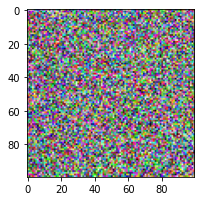

In [ ]:
plt.figure(figsize=(3,4))
plt.imshow(adversarial_patch[0])
plt.show()

### Patch attachment functions

In [ ]:
# Attach a patch on the image at area of the bounding_box
# Works with ndarray

def attach_adversarial_patch(img, bounding_box, patch):
  IMG_RATIO = 0.5
  # IMG_ROTATION = 0.0
  # IMG_BRIGHTNESS = 0.0

  (img_length, img_width, _) = img.shape

  ymin = int(bounding_box[0] * img_length)
  xmin = int(bounding_box[1] * img_width)
  ymax = int(bounding_box[2] * img_length)
  xmax = int(bounding_box[3] * img_width)

  bbox_length = ymax - ymin
  bbox_width = xmax - xmin

  # Convert image to PIL Image object
  img = Image.fromarray(img)
  patch = Image.fromarray(patch)

  # Resize patch to fit in the box
  if bbox_width < bbox_length:
    patch_size = int(bbox_width * IMG_RATIO)
  else:
    patch_size = int(bbox_length * IMG_RATIO)

  patch = patch.resize((patch_size, patch_size))

  # Attach the patch to bounding box
  xstart = int(xmax - bbox_width/2 - patch_size/2)
  ystart = int(ymax - bbox_length/2 - patch_size/2)
  img.paste(patch, (xstart, ystart))

  return np.array(img)

In [ ]:
def attach_adversarial_patch_to_person(element, adversarial_patch):
  person_class_index = 1
  label_id_offset = 1

  num_of_detection = element['objects']['label'].get_shape().as_list()[0]

  new_img = element['image'].numpy()
  patch = tf.cast(adversarial_patch, dtype=tf.uint8).numpy()[0]

  for detection in range(num_of_detection):
    if element['objects']['label'][detection] + label_id_offset == person_class_index and element['objects']['is_crowd'][detection] == False:
      new_img = attach_adversarial_patch(new_img,
                                     element['objects']['bbox'][detection].numpy(),
                                     patch)
  
  new_img = tf.convert_to_tensor(new_img)

  return new_img

In [ ]:
# Mapping function: Attached adversarial patch to person classes
def map_attach_adv_patch(img, imgfilename, imgid, area, bbox, id, is_crowd, label, adversarial_patch):
  person_class_index = 1
  label_id_offset = 1

  num_of_detection = label.get_shape().as_list()[0]

  new_img = img.numpy()
  patch = tf.cast(adversarial_patch, dtype=tf.uint8).numpy()[0]

  for detection in range(num_of_detection):
    if label[detection] + label_id_offset == person_class_index and is_crowd[detection] == False:
      new_img = attach_adversarial_patch(new_img,
                                     bbox[detection].numpy(),
                                     patch)
  
  new_img = tf.convert_to_tensor(new_img)
  return (new_img, imgfilename, imgid, area, bbox, id, is_crowd, label)


In [ ]:
# Workaround to have tensor inputs to py_function for dataset mapping
def deconstruct_dict_and_mapping(img, imgfilename, imgid, area, bbox, id, is_crowd, label, adversarial_patch):
  element = map_attach_adv_patch(img, imgfilename, imgid, area, bbox, id, is_crowd, label, adversarial_patch)
  return element


In [ ]:
# Workaround to return a dictionary to the dataset mapping function
def reconstruct_dict(img, imgfilename, imgid, area, bbox, id, is_crowd, label):
  return {'image': img,
          'image/filename': imgfilename,
          'image/id': imgid,
          'objects': {
              'area': area,
              'bbox': bbox,
              'id': id,
              'is_crowd': is_crowd,
              'label': label
          }}


## Load @ Model

### Load R-CNN Model

#### Method 1: TensorFlow Hub

In [ ]:
detector = hub.load("https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_1024x1024/1")

In [ ]:
detector_keras_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_1024x1024/1")

In [ ]:
print(detector_keras_layer.get_config())
print(detector_keras_layer.trainable_variables)

{'name': 'keras_layer', 'trainable': False, 'dtype': 'float32', 'handle': 'https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_1024x1024/1'}
[]


#### Method 2: Eager Few Shot Object Detection:

In [ ]:
# Download the checkpoint and put it into models/research/object_detection/test_data/
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/faster_rcnn_resnet50_v1_640x640_coco17_tpu-8.tar.gz
!tar -xf faster_rcnn_resnet50_v1_640x640_coco17_tpu-8.tar.gz
!mv faster_rcnn_resnet50_v1_640x640_coco17_tpu-8/checkpoint models/research/object_detection/test_data/

--2022-04-06 11:58:07--  http://download.tensorflow.org/models/object_detection/tf2/20200711/faster_rcnn_resnet50_v1_640x640_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 142.250.152.128, 2607:f8b0:4001:c56::80
Connecting to download.tensorflow.org (download.tensorflow.org)|142.250.152.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 211996178 (202M) [application/x-tar]
Saving to: ‘faster_rcnn_resnet50_v1_640x640_coco17_tpu-8.tar.gz’

faster_rcnn_resnet5 100%[===================>] 202.17M   237MB/s    in 0.9s    

2022-04-06 11:58:08 (237 MB/s) - ‘faster_rcnn_resnet50_v1_640x640_coco17_tpu-8.tar.gz’ saved [211996178/211996178]



In [ ]:
# Resets all state generated by Keras
tf.keras.backend.clear_session()

print('Building model and restoring weights for fine-tuning...', flush=True)
pipeline_config = 'models/research/object_detection/configs/tf2/faster_rcnn_resnet50_v1_fpn_640x640_coco17_tpu-8.config'
checkpoint_path = 'models/research/object_detection/test_data/checkpoint/ckpt-0'

# Load pipeline config and build a detection model.
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']

detection_model = model_builder.build(
      model_config=model_config, is_training=False, add_summaries=True)

Building model and restoring weights for fine-tuning...


In [ ]:
# Restore model checkpoint
# ckpt = tf.train.Checkpoint(model=detection_model)
# ckpt.restore(checkpoint_path).expect_partial()

In [ ]:
# Debug - preprocessing inputs
(preprocessed_input, true_image_shape) = detection_model.preprocess(tf.zeros([1, 640, 640, 3]))

In [ ]:
# Debug - making prediction
prediction = detection_model.predict(preprocessed_input, true_image_shape)

INFO:tensorflow:depth of additional conv before box predictor: 0


INFO:tensorflow:depth of additional conv before box predictor: 0


INFO:tensorflow:depth of additional conv before box predictor: 0


INFO:tensorflow:depth of additional conv before box predictor: 0


INFO:tensorflow:depth of additional conv before box predictor: 0


INFO:tensorflow:depth of additional conv before box predictor: 0


INFO:tensorflow:depth of additional conv before box predictor: 0


INFO:tensorflow:depth of additional conv before box predictor: 0


INFO:tensorflow:depth of additional conv before box predictor: 0


INFO:tensorflow:depth of additional conv before box predictor: 0


In [ ]:
postprocessed_prediction = detection_model.postprocess(prediction, true_image_shape)

Instructions for updating:
`tf.batch_gather` is deprecated, please use `tf.gather` with `batch_dims=-1` instead.


Instructions for updating:
`tf.batch_gather` is deprecated, please use `tf.gather` with `batch_dims=-1` instead.


In [ ]:
for key in postprocessed_prediction.keys():
  print(key)

detection_boxes
detection_scores
detection_classes
detection_multiclass_scores
detection_anchor_indices
num_detections
raw_detection_boxes
raw_detection_scores


### Load YOLOv2 Model

## Define Loss Function

In [ ]:
def loss_function_testing(result):
  person_class_index = 1

  num_of_people_detected = tf.math.count_nonzero(tf.cast(tf.math.equal(result['detection_classes'], person_class_index - 1), tf.int8))

  loss = num_of_people_detected

  return loss

### Define Optimizer

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)

## Training Session

In [ ]:
# Test on single image:
for step, element_debug in enumerate(ds_train):
  if step < 1:
    image_debug_adv = attach_adversarial_patch_to_person(element_debug, adversarial_patch)

    with tf.GradientTape() as tape:
      tape.watch(adversarial_patch)

      preprocessed_input = tf.expand_dims(image_debug_adv, axis=0)
      prediction = detector(preprocessed_input)
      loss = loss_function_testing(prediction)

    grads = tape.gradient(loss, adversarial_patch)
    print(grads.get_shape())

AttributeError: ignored

In [ ]:
epochs = 2
for epoch in range(epochs):
  print("\nStart of epoch %d" % (epoch,))
  losses = []

  # To-do: Proprocess dataset

  # Iterate over the batches of the dataset.
  for step, element_train in enumerate(ds_train):
    # Apply adversarial patch to single element
    image_train_adv = attach_adversarial_patch_to_person(element_train, adversarial_patch)
    
    # Open a GradientTape to record the operations run
    # during the forward pass, which enables auto-differentiation.
    with tf.GradientTape() as tape:
      tape.watch(adversarial_patch)

      preprocessed_input = tf.expand_dims(image_train_adv, axis=0)
      prediction = detector(preprocessed_input)
      loss = loss_function_testing(prediction)

    # Use the gradient tape to automatically retrieve
    # the gradients of the trainable variables with respect to the loss.
    grads = tape.gradient(loss, adversarial_patch)

    # Run one step of gradient descent by updating
    # the value of the variables to minimize the loss.
    optimizer.apply_gradients(zip(grads, adversarial_patch))

    losses.append(loss)
    
  average_loss = tf.math.reduce_mean(losses)
  print("End of epoch: average loss = %d" % (average_loss,))
  print("Latest adversarial patch pattern: ")
  plt.figure(figsize=(3,4))
  plt.imshow(adversarial_patch[0])
  plt.show()



Start of epoch 0


ValueError: ignored